In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import square, stft

from scipy.signal.windows import gaussian


In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

In [4]:
from src.DataLoader import *

def load_data(csv_file_path):
    """
    Reads a CSV file, checks if the time vector is equally spaced,
    deduces the sampling rate, and resamples the dataset at 32 Hz.
    Returns a DataFrame with columns 'Time [s]', 'X_acceleration',
    'Y_acceleration', and 'Z_acceleration'.

    Args:
        csv_file_path (str): Path to the input CSV file.

    Returns:
        pd.DataFrame: Resampled DataFrame with columns 'X_acceleration',
                      'Y_acceleration', 'Z_acceleration', and 'New_Time'.
    """
    # original data sampling rate

    orig_sampling_rate = 32 # [Hz]

    try:
        # Read the CSV file and skip the first row
        df = pd.read_csv(csv_file_path, header=None)

        # Remove the first row (index 0)
        df = df.iloc[1:]

        # Rename columns (adjust column names as needed)
        column_mapping = {
            0: 'Time [s]',
            1: 'X_acceleration',
            2: 'Y_acceleration',
            3: 'Z_acceleration',
            4: 'Absolute_acceleration'
        }
        df.rename(columns=column_mapping, inplace=True)

        # Convert all columns to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Compute differences between consecutive time values
        time_diff = df['Time [s]'].diff()

        # Calculate the mean of time differences
        mean_time_diff = round(time_diff.mean(), 3)

        # Calculate the sampling rate

        sampling_rate = 1 / mean_time_diff

        # Create a new column 'New_Time' starting from 0 and incrementing by mean_time_diff
        df['New_Time'] = pd.Series(range(len(df))) * mean_time_diff

        # Set the index to the 'New_Time' column
        df.set_index('New_Time', inplace=True)

        # Convert the index to a datetime-like index
        df.index = pd.to_timedelta(df.index, unit='s')

        # Resample the dataframe to 32 Hz

        df = df.resample('31.25ms').mean()

        return df[['X_acceleration', 'Y_acceleration', 'Z_acceleration']]

    except FileNotFoundError:
        print(f"Error: CSV file '{csv_file_path}' not found.")
        return None

In [5]:
from sklearn.pipeline import make_pipeline

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn.model_selection import learning_curve

In [9]:
from sklearn.model_selection import cross_validate

In [10]:
from sklearn.metrics import accuracy_score

In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [12]:
import pickle

In [13]:
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [ ]:
subject_ = f's{1}'
data_p = DataLoader().load_ACC_data(subject=subject_,event='morning')

#data_p = load_data()

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data_p.drop(columns='UNIX_time'))

In [46]:
datas_m = []
for i in range(1,24):
    subject_ = f's{i}'
    data = DataLoader().load_ACC_data(subject=subject_,event='morning')
    data.drop(columns='UNIX_time',inplace=True)

    #new bit, NJ Monday
    data = data.reset_index(drop=True)
    #divides each df into 90 second chunks
    for chunk in range(20):
        #adds first 90 second chunk to the output list
        chunk_of_90 = data[:2880]
        flat_chunk_of_90 = chunk_of_90.to_numpy().flatten()
        datas_m.append(flat_chunk_of_90)
        #discards first 90 second chunk
        data = data.iloc[2880:]


In [40]:
datas_e = []
for i in range(1,24):
    subject_ = f's{i}'
    data = DataLoader().load_ACC_data(subject=subject_,event='evening')
    data.drop(columns='UNIX_time',inplace=True)

    #new bit, NJ Monday
    data = data.reset_index(drop=True)
    #divides each df into 90 second chunks
    for chunk in range(20):
        #adds first 90 second chunk to the output list
        chunk_of_90 = data[:2880]
        flat_chunk_of_90 = chunk_of_90.to_numpy().flatten()
        datas_e.append(flat_chunk_of_90)
        #discards first 90 second chunk
        data = data.iloc[2880:]

In [42]:
len(datas_m)

0

In [47]:
datas_m[0].shape

(8640,)

In [45]:
datas_e[0].shape

(8640,)

In [48]:
array = np.concatenate((datas_m, datas_e), axis=0)

In [49]:
datas = pd.DataFrame(array)

In [50]:
datas.shape

(920, 8640)

In [51]:
def normalization(subject):
    num_transformer=make_pipeline(StandardScaler())
    num_transformer.fit(subject)
    return pd.DataFrame(num_transformer.transform(subject),columns=subject.columns)

In [52]:
df=normalization(datas)

In [53]:
X = df

In [54]:
info = pd.read_excel('data/general_info.xlsx')

In [55]:
sleepy_list = [11, 18, 0, 12, 10, 11, 5, 11, 2, 5, 9, 9, 17, 4, 2, 12, 12, 19, 13, 7, 11, 3, 5, 14, 14, 14, 12, 13, 11, 1, 11, 13, 11, 8, 19, 21, 22, 16, 15, 12, 26, 4, 19, 21, 18, 20]

sleepy_df = pd.DataFrame(sleepy_list)

In [56]:
sleepy_df["fatigue"] = sleepy_df[0]

sleepy_df = sleepy_df.drop(columns=0)

sleepy_df["is_tired"] = 0

sleepy_df['is_tired'] = (sleepy_df['fatigue'] > 11).astype(int)

In [57]:
sleepy_df_20split = pd.DataFrame(np.repeat(sleepy_df.values, 20, axis=0))
sleepy_df_20split.columns = sleepy_df.columns
sleepy_df_20split.shape

(920, 2)

In [58]:
y = sleepy_df_20split.is_tired

In [59]:
y.value_counts()

is_tired
1    480
0    440
Name: count, dtype: int64

<Axes: ylabel='is_tired'>

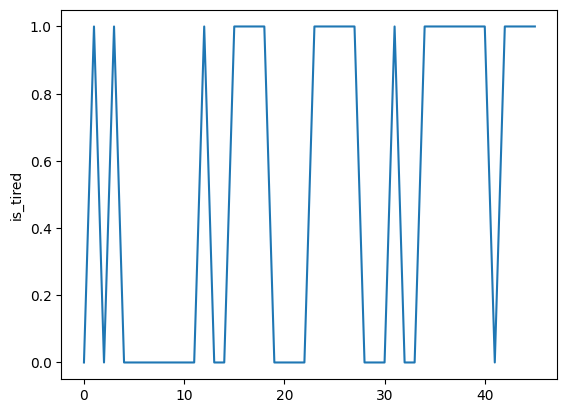

In [62]:
sns.lineplot(sleepy_df['is_tired'])

<Axes: ylabel='is_tired'>

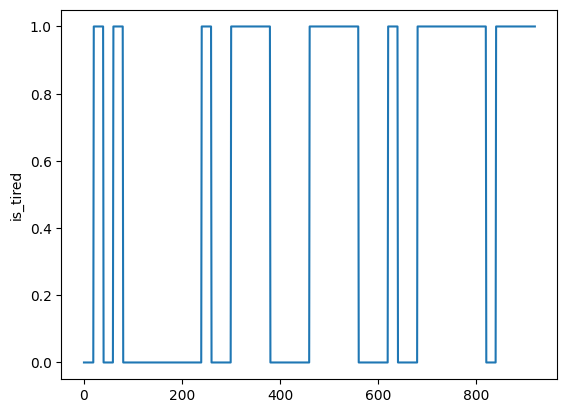

In [61]:
sns.lineplot(y)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 128)

In [64]:
def test_classifiers(X_train, y_train, X_test, y_test):
    models = {
        'MLP Classifier': MLPClassifier(learning_rate="invscaling", hidden_layer_sizes=[4,4]),  ## --> This is your baseline = chance
        'Decision Tree': DecisionTreeClassifier(),
        #'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier()
        
    }

    results = {}

    for name, model in models.items():
        pipe = make_pipeline(model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        report = classification_report(y_test, y_pred)
        
        results[name] = {
            'accuracy': accuracy,
            'report': report
        }
        
        print(f"{name}:\n")
        print(f"Accuracy: {accuracy}\n")
        print(f"Classification Report:\n{report}\n")
        
    return results

In [65]:
test_classifiers(X_train, y_train, X_test, y_test)

MLP Classifier:

Accuracy: 0.5434782608695652

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.74      0.59       125
           1       0.64      0.38      0.48       151

    accuracy                           0.54       276
   macro avg       0.57      0.56      0.54       276
weighted avg       0.57      0.54      0.53       276


Decision Tree:

Accuracy: 0.5217391304347826

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       125
           1       0.57      0.53      0.55       151

    accuracy                           0.52       276
   macro avg       0.52      0.52      0.52       276
weighted avg       0.53      0.52      0.52       276


Random Forest:

Accuracy: 0.6123188405797102

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.60       125
           1       0.66    

{'MLP Classifier': {'accuracy': 0.5434782608695652,
  'report': '              precision    recall  f1-score   support\n\n           0       0.50      0.74      0.59       125\n           1       0.64      0.38      0.48       151\n\n    accuracy                           0.54       276\n   macro avg       0.57      0.56      0.54       276\nweighted avg       0.57      0.54      0.53       276\n'},
 'Decision Tree': {'accuracy': 0.5217391304347826,
  'report': '              precision    recall  f1-score   support\n\n           0       0.47      0.51      0.49       125\n           1       0.57      0.53      0.55       151\n\n    accuracy                           0.52       276\n   macro avg       0.52      0.52      0.52       276\nweighted avg       0.53      0.52      0.52       276\n'},
 'Random Forest': {'accuracy': 0.6123188405797102,
  'report': '              precision    recall  f1-score   support\n\n           0       0.56      0.63      0.60       125\n           1       

In [91]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('mlp', MLPClassifier(learning_rate="invscaling", hidden_layer_sizes=[3,3,3])),
        ('gb', GradientBoostingClassifier())]
)

voting_clf.voting = "soft"
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.6086956521739131

In [68]:
model = MLPClassifier(shuffle=True)

In [80]:
param_grid = {
    'learning_rate': ['invscaling', 'adaptive'],
    #'subsample': [0.8, 0.9, 1.0]
    'hidden_layer_sizes' :[[3,3,3], [4,4], [5,5], [10,10], [20,10,5], [40,20,10]]   
}

In [81]:
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=2
             )

In [82]:
search = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END hidden_layer_sizes=[4, 4], learning_rate=invscaling; total time=   3.9s
[CV] END hidden_layer_sizes=[3, 3, 3], learning_rate=invscaling; total time=   5.0s
[CV] END hidden_layer_sizes=[4, 4], learning_rate=invscaling; total time=   5.2s


/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=[4, 4], learning_rate=invscaling; total time=  10.1s
[CV] END hidden_layer_sizes=[3, 3, 3], learning_rate=invscaling; total time=  10.4s


/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=[3, 3, 3], learning_rate=invscaling; total time=  11.1s
[CV] END hidden_layer_sizes=[3, 3, 3], learning_rate=adaptive; total time=  11.1s
[CV] END ..hidden_layer_sizes=[4, 4], learning_rate=adaptive; total time=   6.2s
[CV] END hidden_layer_sizes=[3, 3, 3], learning_rate=adaptive; total time=  11.3s


/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=[3, 3, 3], learning_rate=adaptive; total time=  11.3s
[CV] END hidden_layer_sizes=[5, 5], learning_rate=invscaling; total time=   4.2s
[CV] END ..hidden_layer_sizes=[4, 4], learning_rate=adaptive; total time=   5.8s
[CV] END ..hidden_layer_sizes=[4, 4], learning_rate=adaptive; total time=   7.1s
[CV] END ..hidden_layer_sizes=[5, 5], learning_rate=adaptive; total time=   7.5s
[CV] END hidden_layer_sizes=[5, 5], learning_rate=invscaling; total time=   9.7s
[CV] END ..hidden_layer_sizes=[5, 5], learning_rate=adaptive; total time=  10.0s
[CV] END hidden_layer_sizes=[10, 10], learning_rate=invscaling; total time=   6.5s
[CV] END ..hidden_layer_sizes=[5, 5], learning_rate=adaptive; total time=  11.1s
[CV] END hidden_layer_sizes=[10, 10], learning_rate=invscaling; total time=   7.0s


/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=[5, 5], learning_rate=invscaling; total time=  14.1s
[CV] END hidden_layer_sizes=[20, 10, 5], learning_rate=invscaling; total time=   8.0s
[CV] END hidden_layer_sizes=[10, 10], learning_rate=adaptive; total time=  12.0s
[CV] END hidden_layer_sizes=[10, 10], learning_rate=adaptive; total time=  12.2s


/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=[10, 10], learning_rate=invscaling; total time=  17.4s
[CV] END hidden_layer_sizes=[10, 10], learning_rate=adaptive; total time=  14.0s
[CV] END hidden_layer_sizes=[20, 10, 5], learning_rate=invscaling; total time=  15.7s
[CV] END hidden_layer_sizes=[20, 10, 5], learning_rate=adaptive; total time=  13.8s
[CV] END hidden_layer_sizes=[20, 10, 5], learning_rate=invscaling; total time=  15.4s
[CV] END hidden_layer_sizes=[20, 10, 5], learning_rate=adaptive; total time=  13.1s
[CV] END hidden_layer_sizes=[20, 10, 5], learning_rate=adaptive; total time=  13.9s
[CV] END hidden_layer_sizes=[40, 20, 10], learning_rate=adaptive; total time=  10.1s
[CV] END hidden_layer_sizes=[40, 20, 10], learning_rate=invscaling; total time=  16.4s
[CV] END hidden_layer_sizes=[40, 20, 10], learning_rate=invscaling; total time=  15.1s
[CV] END hidden_layer_sizes=[40, 20, 10], learning_rate=adaptive; total time=  13.2s
[CV] END hidden_layer_sizes=[40, 20, 10], learning_rate=invscaling; 

In [83]:
search.best_params_

{'hidden_layer_sizes': [5, 5], 'learning_rate': 'adaptive'}

In [84]:
mlp_model = MLPClassifier(learning_rate="invscaling", hidden_layer_sizes=[5,5])

In [85]:
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=[5, 5], learning_rate='invscaling')

In [86]:
y_pred = model.predict(X_test)

In [87]:
accuracy = accuracy_score(y_test, y_pred) 

In [88]:
report = classification_report(y_test, y_pred) 

In [89]:
print(f"Accuracy: {accuracy}\n")
print(f"Classification Report:\n{report}\n")

Accuracy: 0.5362318840579711

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.55      0.52       125
           1       0.59      0.52      0.55       151

    accuracy                           0.54       276
   macro avg       0.54      0.54      0.54       276
weighted avg       0.54      0.54      0.54       276




save the model

In [92]:
# Save the model to a file called 'model.pkl'
with open('voting_clf_model.pkl', 'wb') as file:
     pickle.dump(model, file)